# Marcov Decision Process

### Introduction

##### Шашки

В качестве примера марковского процесса принятия решений можно привести множество настольных игр, например, шашки. Действительно, для того, кто играет за белых, процесс описывается следующим образом:
1.  Агент - сам игрок.
2.  Среда - соперник, играющий за черных.
3.  Состояния - позиции на доске, которые могли получиться за четное число полуходов (т.е. позиции перед ходом белых). Т.к. всех возможных расстановок шашек на доске конечно, то и множество состояний конечно.
4.  Множество действий в каждом состоянии - возможные ходы в текущей позиции. Их объединение по всем состояниям даст множество всех действий.
5.  Награда за промежуточный ход - 0, за победу - 1, за поражение - (-1).

Ясно, что в такой естественной модели решение не зависит от предыдущих состояний и выбранных действий. Поэтому мы получаем марковский процесс. Заметим, что агенту неизвестно распределение вероятностей, т.е. ходов соперника.

##### Шахматы

Примером настольной игры, где естественная модель не будет являться марковским процессом, являются шахматы. Допустим, мы хотим модель, аналогичную описанной для шашек, где в качестве состояний используются позиции на доске. Однако здесь возникнут проблемы, связанные со спецификой правил:
1.  Если король или ладья совершали ход в течении партии, а после вернулись на исходные клетки, рокировку в соответствующую сторону делать нельзя. Но, лишь глядя на позицию, этого определить не получится.
2.  Если пешка сходила с исходной клетки на две клетку вперед и оказалась на одной горизонтали и на соседней вертикали с пешкой оппонента, последний имеет право на взятие на проходе. Если же пешка попала в аналогичную позицию за два хода, взятие на проходе не допускается. Отметим, что и эту ситуацию невозможно определить, имея информацию лишь о текущем расположении фигур.
3.  Игрок имеет право потребовать ничью (т.е. прийти в терминальное состояние в рамках модели), если за последние 50 ходов ни одна пешка не делала ход и ни одна фигура не была срублена. Это также невозможно определить по позиции.

Таким образом, в рамках естественной модели для шахмат не получится даже определить возможные действия из некоторых состояний. Значит, такая модель не будет представлять из себя марковский процесс принятия решений, т.к. последующие действия зависят от предыдущих действий и состояний.

##### Связь значений

Рассмотрим, как связаны некоторые значения в рамках рассматриваемой модели:

1.  $r(s, a) = \sum_{s', r}rp(s', r'|s, a)$ - средняя награда из состояния $s$ по действию $a$.
2.  $p(s'|s, a) = \sum_r p(s', r|s, a)$ - вероятность перехода в состояние $s'$ из состояния $s$ по действию $a$.
3.  Средний выигрыш по переходу из $s$ в $s'$ по действию $a$: $$r(s, a, s') = \frac{\sum_rp(s', r|s, a)}{p(s'|s, a)}.$$

Перейдем к реализации. Для удобства будем считать, что нам заранее известны средние значения выигрышей по конкретным переходам.

### Implementation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(228)

Для начала зададим среду. Пусть имеется $S$ состояний и $A$ действий. Среда определяется двумя характеристиками: матрицей переходов $T$ размера $A \times S \times S$ и матрицей наград R такого же размера. Элемент $T_{a, s_1, s_2}$ задает вероятность перехода из состояния $s_1$ в состояние $s_2$ при выборе действия $a$. Элемент $R_{a, s_1, s_2}$ равен математическому ожиданию награды $R$ при переходе из состояния $s_1$ в состояние $s_2$ по действию $a$.

In [2]:
class Environment(object):
    def __init__(self, states, actions):
        self.probabilities = np.zeros((actions, states, states))
        self.rewards = np.zeros((actions, states, states))
        for action in range(actions):
            for state in range(states):
                mask = np.random.random(states)
                p = np.random.random() / 2 + 0.25
                mask[mask >= p] = 1
                mask[mask < p] = 0
                if mask.max() == 0:
                    mask[np.random.randint(0, states)] = 1
                self.probabilities[action, state, :] = np.random.random(states) * mask
                self.probabilities[action, state, :] /= self.probabilities[action, state, :].sum()
                self.rewards[action, state, :] = (np.random.poisson(lam=10, size=states)) * mask
    
    def getTransitions(self):
        return self.probabilities
    
    def getRewards(self):
        return self.rewards

Теперь смоделируем непосредственно Марковский процесс принятия решений. Для сравнения скорости сходимости двух методов ($value \ iteration$ и $policy \ iteration$) обучим модель с очень маленьким значением $\varepsilon$ (скажем, $10^{-10}$). Можно убедиться, что при таких значениях оба метода дадут почти равные оценки состояний. Назовем полученную функцию оценки состояний $base$. Далее будем на каждой итерации с разумным значением $\varepsilon$ (пусть $10^{-4}$) сравнивать сравнивать $base$ и текущую функцию оценки состояния. Для этого определим следующее значение:
$$variation(V, V') = \max\limits_{s \in S} \left|V_s - V'_s \right|.$$
Ясно, что чем меньше значение $variation(base, current)$, тем ближе текущая оценка позиции к эталонной. Также будем запоминать время каждого сравнения.

In [3]:
'''Markov Decision Process model
----------------------------------------------
S - number of states
A - number of actions

T = array[A x S x S] - matrix of transition probabilities:
    T[a, s1, s2] - probability of state s2, when action a is chosen in state s1
R = array[A x S x S] - matrix of expected rewards:
    R[a, s1, s2] - expected reward for transition from state s1 to state s2 by action a

discount - coefficient of discounting from [0, 1)
----------------------------------------------
V = array[S] - state-value function
Q = array[A x S] - action-value function

policy = array[A x S] - policy: policy[a, s] - probability of choosing action a in state s
----------------------------------------------
cmp - flag of comparison, if true,
    the variation between base and current state-value functions is computed
history - information about state-value function, the list of tuples (v, t),
    where v is the variation in the moment t
time0 - to set the timer to the beginning of learning
----------------------------------------------
'''

class MDP(object):
    def __init__(self, T, R, discount):        
        self.S = T.shape[1]
        self.A = T.shape[0]
        self.T = T
        self.R = R
        self.discount = discount
        self.V = np.random.normal(size=self.S)
        self.Q = np.zeros((self.A, self.S))
        self.__initPolicy__()
        self.history = []
        self.time0 = 0
        self.cmp = 0
    
    def __initPolicy__(self):
        self.policy = np.zeros((self.A, self.S))
        # choosing policy that maximizes immediate reward in every state
        for state in range(self.S):
            actions_exp_rewards = self.__calculateActionRewards__(state, discounting=0)
            best_actions = np.where(actions_exp_rewards == np.max(actions_exp_rewards))[0]
            for action in best_actions:
                self.policy[action, state] = 1 / best_actions.shape[0]
    
    def __iterativePolicyEval__(self, epsilon, baseV, max_iter=1000):
        done = 0
        iteration = 0
        while not done:
            iteration += 1
            V_prev = np.copy(self.V)
            for state in range(self.S):
                actions_exp_rewards = self.__calculateActionRewards__(state)
                self.V[state] = np.sum(actions_exp_rewards * self.policy[:, state], axis=0)
                
            variation = np.abs(V_prev - self.V).max()
            if variation < epsilon or iteration > max_iter:
                done = 1
            if self.cmp:
                base_variation = np.abs(self.V - baseV).max()
                self.history.append([base_variation, time.time() - self.time0])
        return iteration, variation
    
    def __policyImprovement__(self):
        for state in range(self.S):
            old_actions = np.copy(self.policy[:, state])
            actions_exp_rewards = self.__calculateActionRewards__(state)
            best_actions = np.where(actions_exp_rewards == np.max(actions_exp_rewards))[0]
            self.policy[:, state] = 0
            for action in best_actions:
                self.policy[action, state] = 1 / best_actions.shape[0]
            if not np.all(self.policy[:, state] == old_actions):
                self.stable_policy = 0
            del old_actions
    
    def policyIteration(self, epsilon=1e-4, verbose=0, baseV=np.zeros((0,0))):
        if baseV.any():
            self.cmp = 1
        else:
            self.cmp = 0
        self.history = []
        self.time0 = time.time()
        self.stable_policy = 0
        inner_iterations = 0
        while not self.stable_policy:
            current_iterations, variation = self.__iterativePolicyEval__(epsilon=epsilon, baseV=baseV)
            inner_iterations += current_iterations
            self.stable_policy = 1
            self.__policyImprovement__()
            if verbose:
                print('Iterations: ' + str(inner_iterations), end='\t')
                print('\ttime: ' + str(time.time() - self.time0), end='\t')
                print('\tVariation: ' + str(variation))
            
    def valueIteration(self, epsilon=1e-4, verbose=0, baseV=np.zeros((0,0))):
        self.history = []
        if baseV.any():
            self.cmp = 1
        else:
            self.cmp = 0
        delta = epsilon
        self.time0 = time.time()
        iters = 1
        variation = 0
        while delta >= epsilon:
            delta = 0
            for state in range(self.S):
                v_prev = self.V[state]
                actions_exp_rewards = self.__calculateActionRewards__(state)
                self.V[state] = np.max(actions_exp_rewards)
                variation = np.abs(v_prev - self.V[state])
                delta = max(variation, delta)
            if self.cmp:
                base_variation = np.abs(self.V - baseV).max()
                self.history.append([base_variation, time.time() - self.time0])
            if verbose:
                print('Iteration: ' + str(iters), end='\t')
                print('\ttime: ' + str(time.time() - time0), end='\t')
                print('\tVariation: ' + str(variation))
            iters += 1
        self.__policyImprovement__()        
    
    def  __calculateActionRewards__(self, state, discounting=1):
        return np.sum(self.T[:, state, :] * (self.R[:, state, :] + \
                                             discounting * self.discount * self.V), axis=1)
    
    def getPolicy(self):
        return self.policy
    
    def getStateEval(self):
        return self.V

Сгенерируем среду с 50 действиями и 100 состояниями.

In [4]:
S = 100
A = 50

env = Environment(S, A)
P = env.getTransitions()
R = env.getRewards()

Возьмем параметр дисконтирования равный $0.8$. Запустим два метода с $\varepsilon = 10^{-10}$. Убедимся, что функции оценки состояний почти равны и запомним функцию для одной из модели. Также запомним стратегию.

In [5]:
mdpPIbase = MDP(P, R, 0.8)
mdpPIbase.policyIteration(1e-10, verbose=0)
mdpVIbase = MDP(P, R, 0.8)
mdpVIbase.valueIteration(1e-10, verbose=0)
print(np.abs(mdpPIbase.getStateEval() - mdpVIbase.getStateEval()).sum())
baseStateEval = mdpVIbase.getStateEval()
basePolicy = mdpVIbase.getPolicy()

1.10816955612e-09


### Comparison
Теперь сравним сходимость методов. Положим $\varepsilon = 0.4$. Будем использовать вышеописанный метод.

In [6]:
mdpPI = MDP(P, R, 0.8)
mdpPI.policyIteration(1e-4, 0, baseStateEval)
mdpVI = MDP(P, R, 0.8)
mdpVI.valueIteration(1e-4, 0, baseStateEval)
historyVI = np.array(mdpVI.history)
historyPI = np.array(mdpPI.history)

Убедимся, что стратегии получились одинаковыми.

In [7]:
np.array_equal(basePolicy, mdpPI.getPolicy()) and np.array_equal(basePolicy, mdpVI.getPolicy())

True

Наконец, посмотрим на графики в осях $time \times variation$.

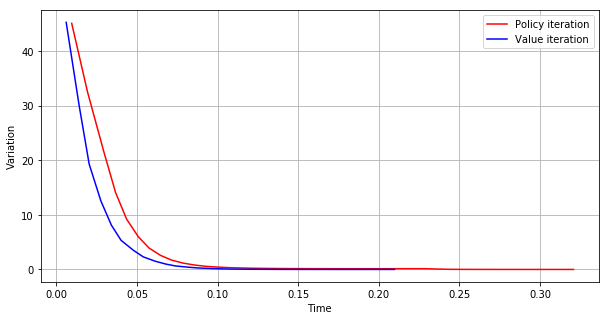

In [8]:
fig = plt.figure(figsize=(10, 5))

plt.plot(historyPI[:, 1], historyPI[:, 0], c='red', label='Policy iteration')
plt.plot(historyVI[:, 1], historyVI[:, 0], c='blue', label='Value iteration')

plt.xlabel('Time')
plt.ylabel('Variation')
plt.legend()
plt.grid()
plt.show()

Видно, что оба метода сходятся достаточно быстро, однако в данной задаче $value \ iteration$ сходится значительно быстрее, поэтому далее будем рассматривать его.

Рассмотрим, как меняется значение $state \ value$ функции для некоторых состояний в зависимости от значения параметра дисконтирования.

In [9]:
discounters = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
values = np.zeros((len(discounters), S))
for d in range(len(discounters)):
    mdp = MDP(P, R, discounters[d])
    mdp.valueIteration(1e-6)
    values[d, :] = mdp.getStateEval()

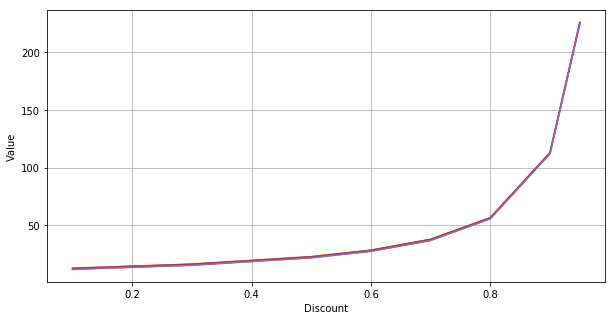

In [10]:
fig = plt.figure(figsize=(10, 5))

states = [0, 10, 20, 30, 40]

for s in range(len(states)):
    plt.plot(discounters, values[:, s])

plt.xlabel('Discount')
plt.ylabel('Value')
plt.grid()
plt.show()

Видно, что при стремлении параметра к 1 значения сильно растут, что ожидаемо ввиду определения $state \ value$ функции через ряды. При малых значениях параметра значения функции, напротив, убывают, однако медленно.